# Importa & Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
sns.set()
sns.set_palette('PuOr')
SNS_CMAP = 'PuOr'
accent1 = {'0': 'orange', '1': 'purple'}

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/competitions/playground-series-s4e1/data')

100%|██████████| 6.81M/6.81M [00:00<00:00, 43.5MB/s]


Extracting archive ./playground-series-s4e1/playground-series-s4e1.zip to ./playground-series-s4e1


In [ ]:
import os
mode = "colab"
if mode=="kaggle":
  base_path = '/kaggle/input/playground-series-s4e1'
else:
  base_path = '/content/playground-series-s4e1'

df = pd.read_csv(os.path.join(base_path, 'train.csv'))
df_test = pd.read_csv(os.path.join(base_path, 'test.csv'))
df_sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [ ]:
df.head().style.background_gradient(cmap='Purples')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.000000,3,0.000000,2,1.000000,0.000000,181449.970000,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.000000,1,0.000000,2,1.000000,1.000000,49503.500000,0
2,2,15694510,Hsueh,678,France,Male,40.000000,10,0.000000,2,1.000000,0.000000,184866.690000,0
3,3,15741417,Kao,581,France,Male,34.000000,2,148882.540000,1,1.000000,1.000000,84560.880000,0
4,4,15766172,Chiemenam,716,Spain,Male,33.000000,5,0.000000,2,1.000000,1.000000,15068.830000,0


In [ ]:
df.describe().style.background_gradient(cmap='Oranges')

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.500000,15692005.019026,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.356500,71397.816791,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.250000,15633141.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.500000,15690169.000000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.750000,15756824.000000,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [ ]:
df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T

# EDA

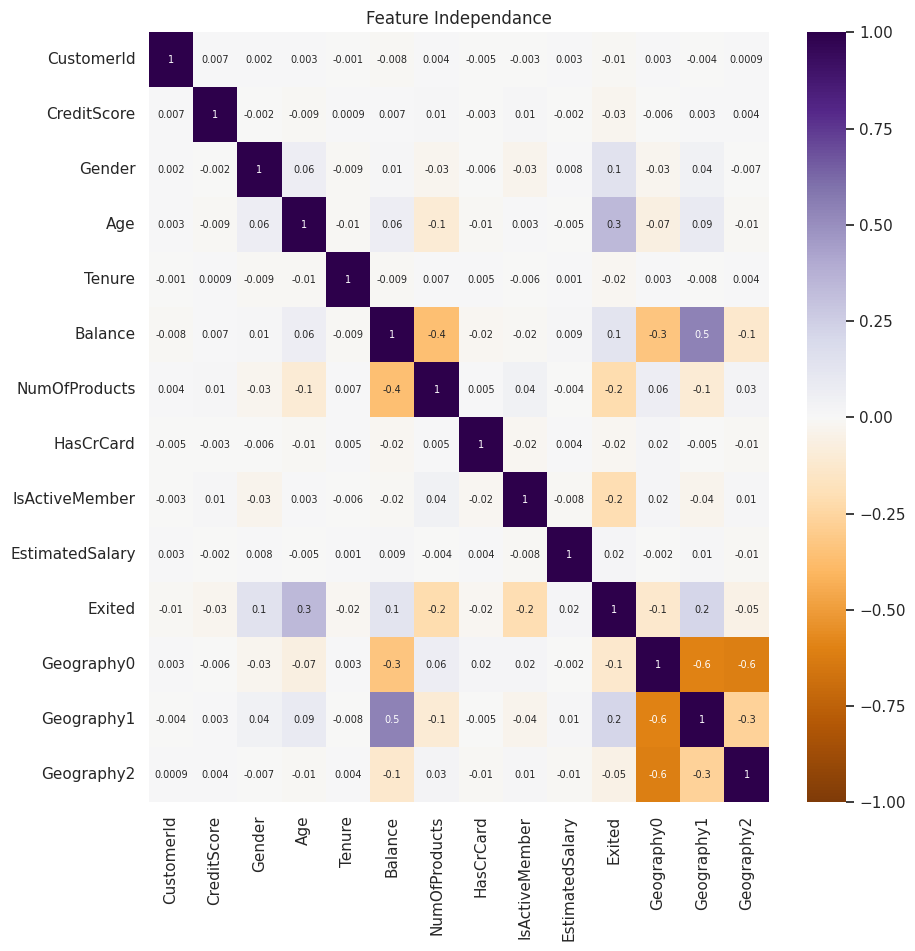

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Feature Independance")
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sns.heatmap(df.select_dtypes(include=numerics).corr(), cmap=SNS_CMAP, annot=True, annot_kws={'fontsize':7}, fmt='.1g', vmin=-1, vmax=1, center= 0)
plt.show()

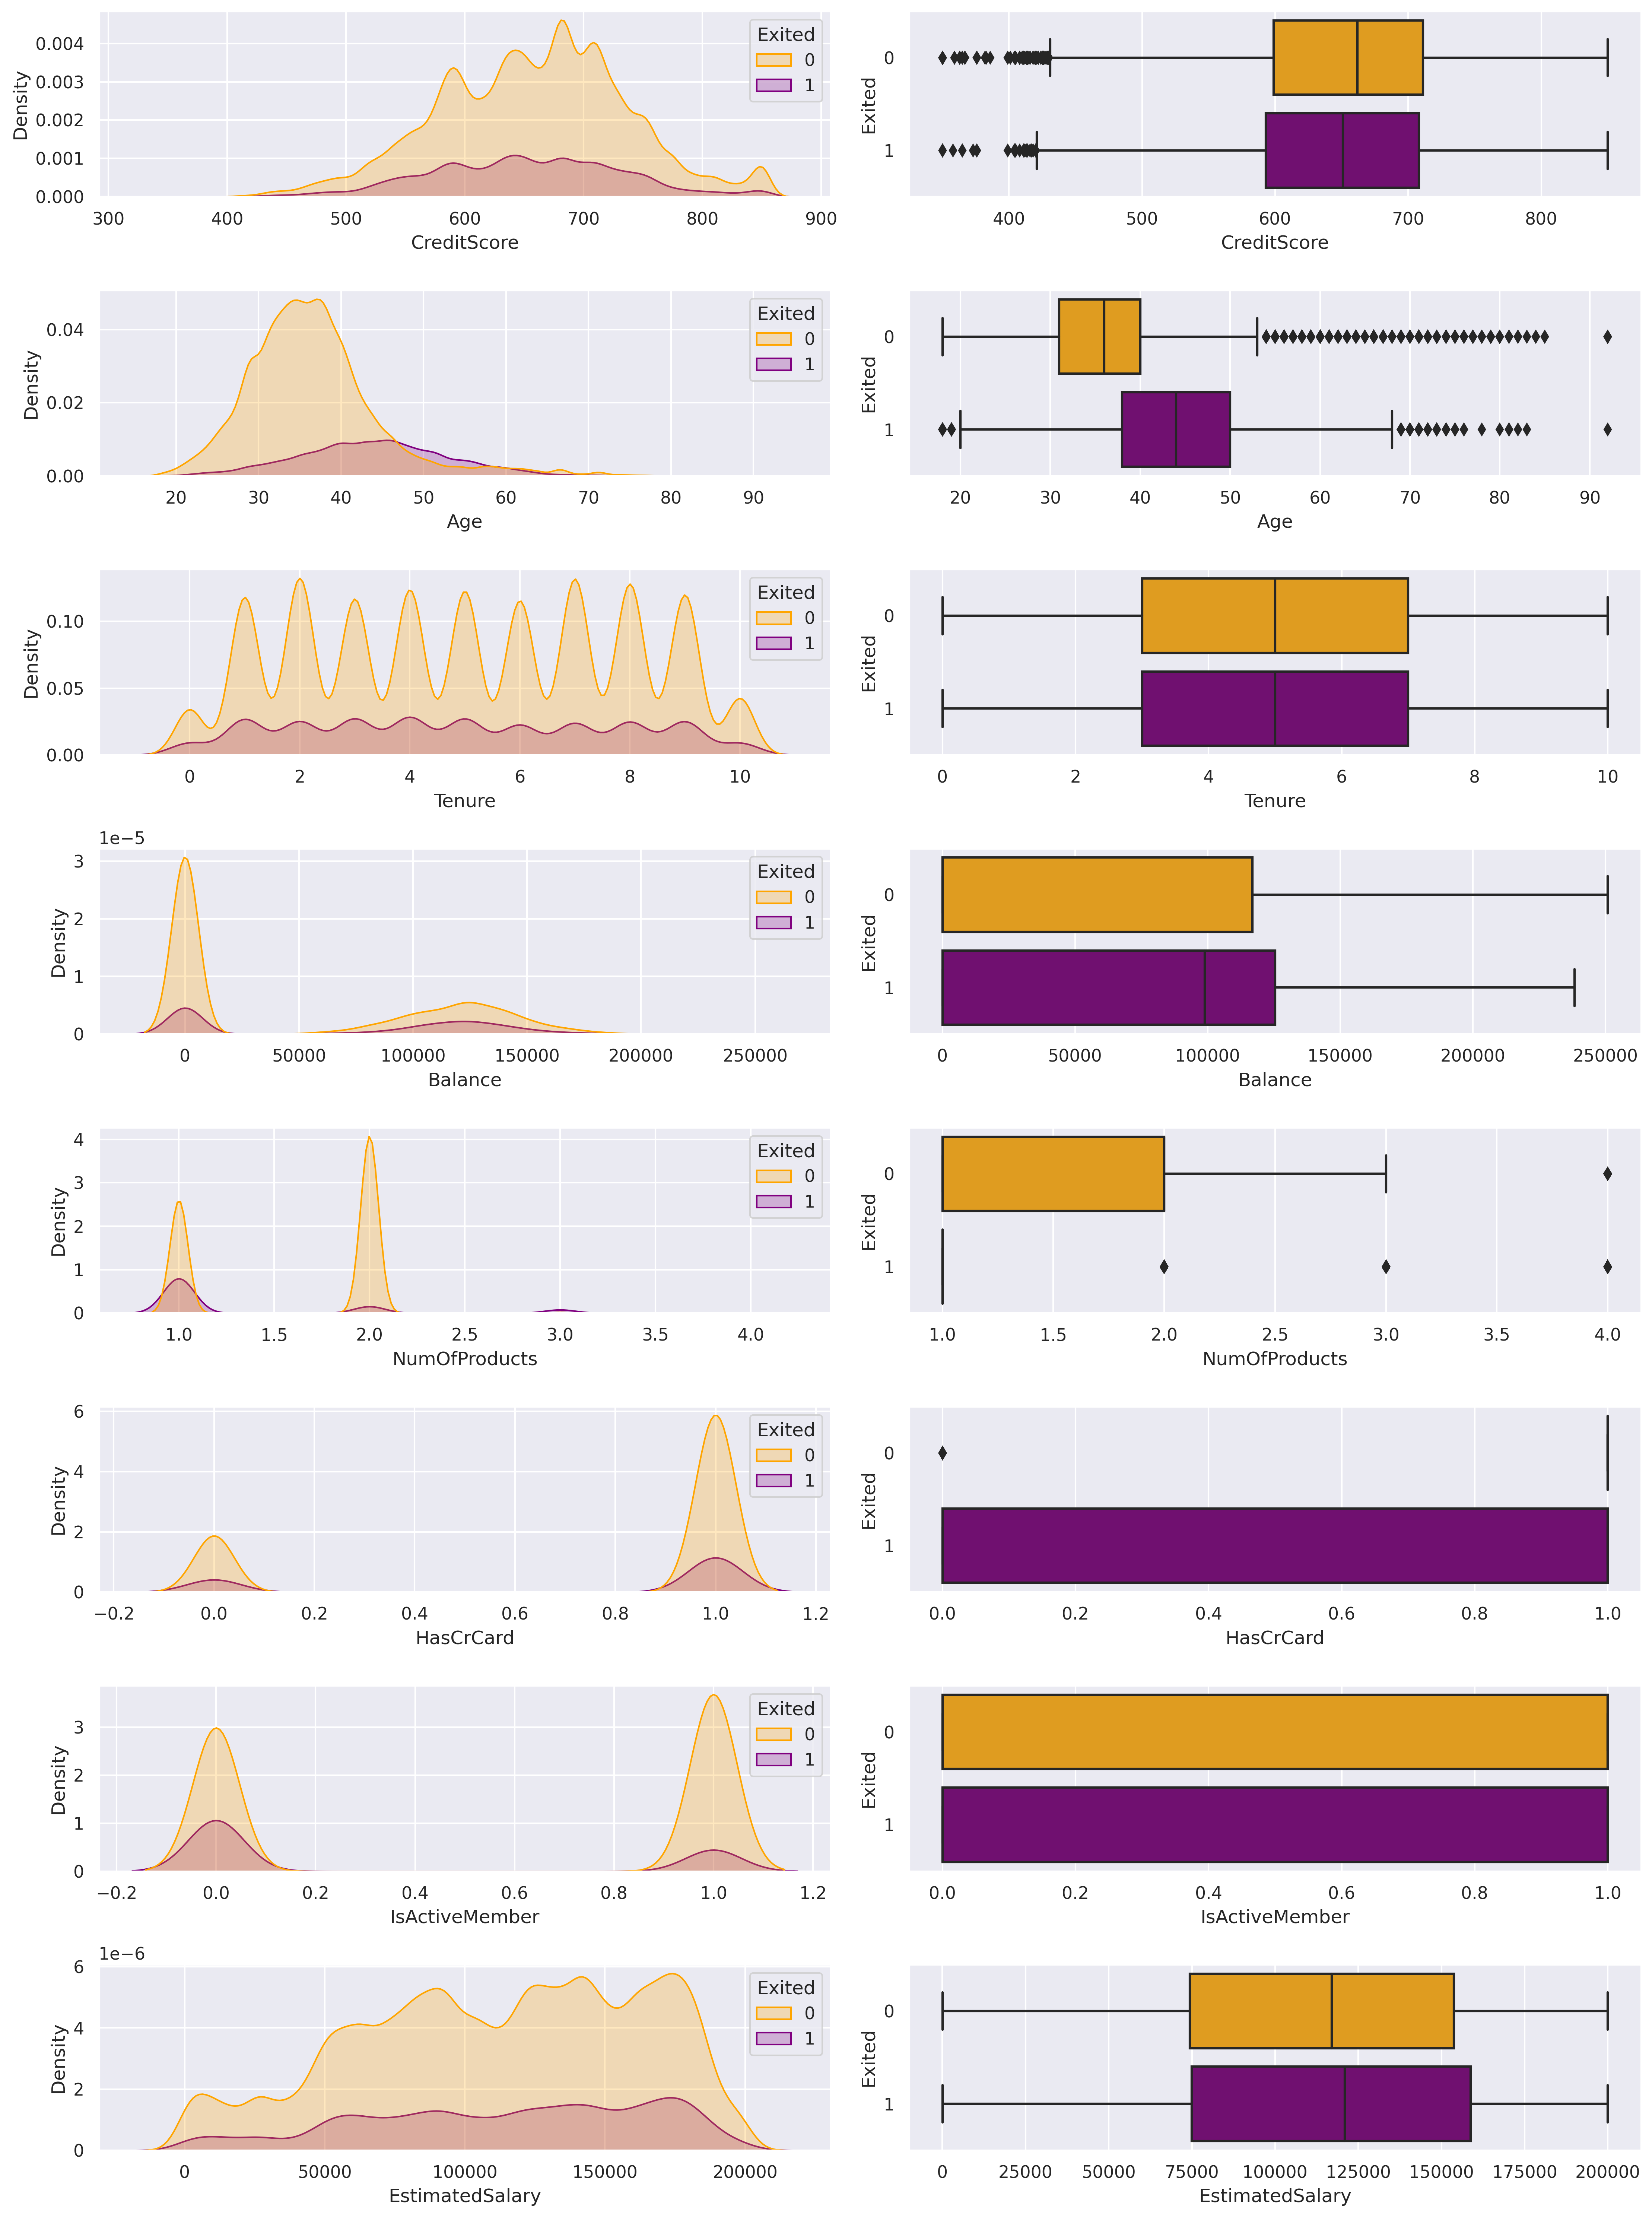

In [ ]:
cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
n_columns = len(cols)
fig,axes = plt.subplots(n_columns, 2,figsize=(15, 20),dpi=300)
for i, col in enumerate(cols):
    sns.kdeplot(data = df, x=col, hue=df['Exited'].astype(str), fill=True, ax=axes[i][0], palette=accent1)
    sns.boxplot(x=df[col], y=df['Exited'].astype(str), ax=axes[i][1], palette=accent1)
fig.tight_layout()
plt.show()

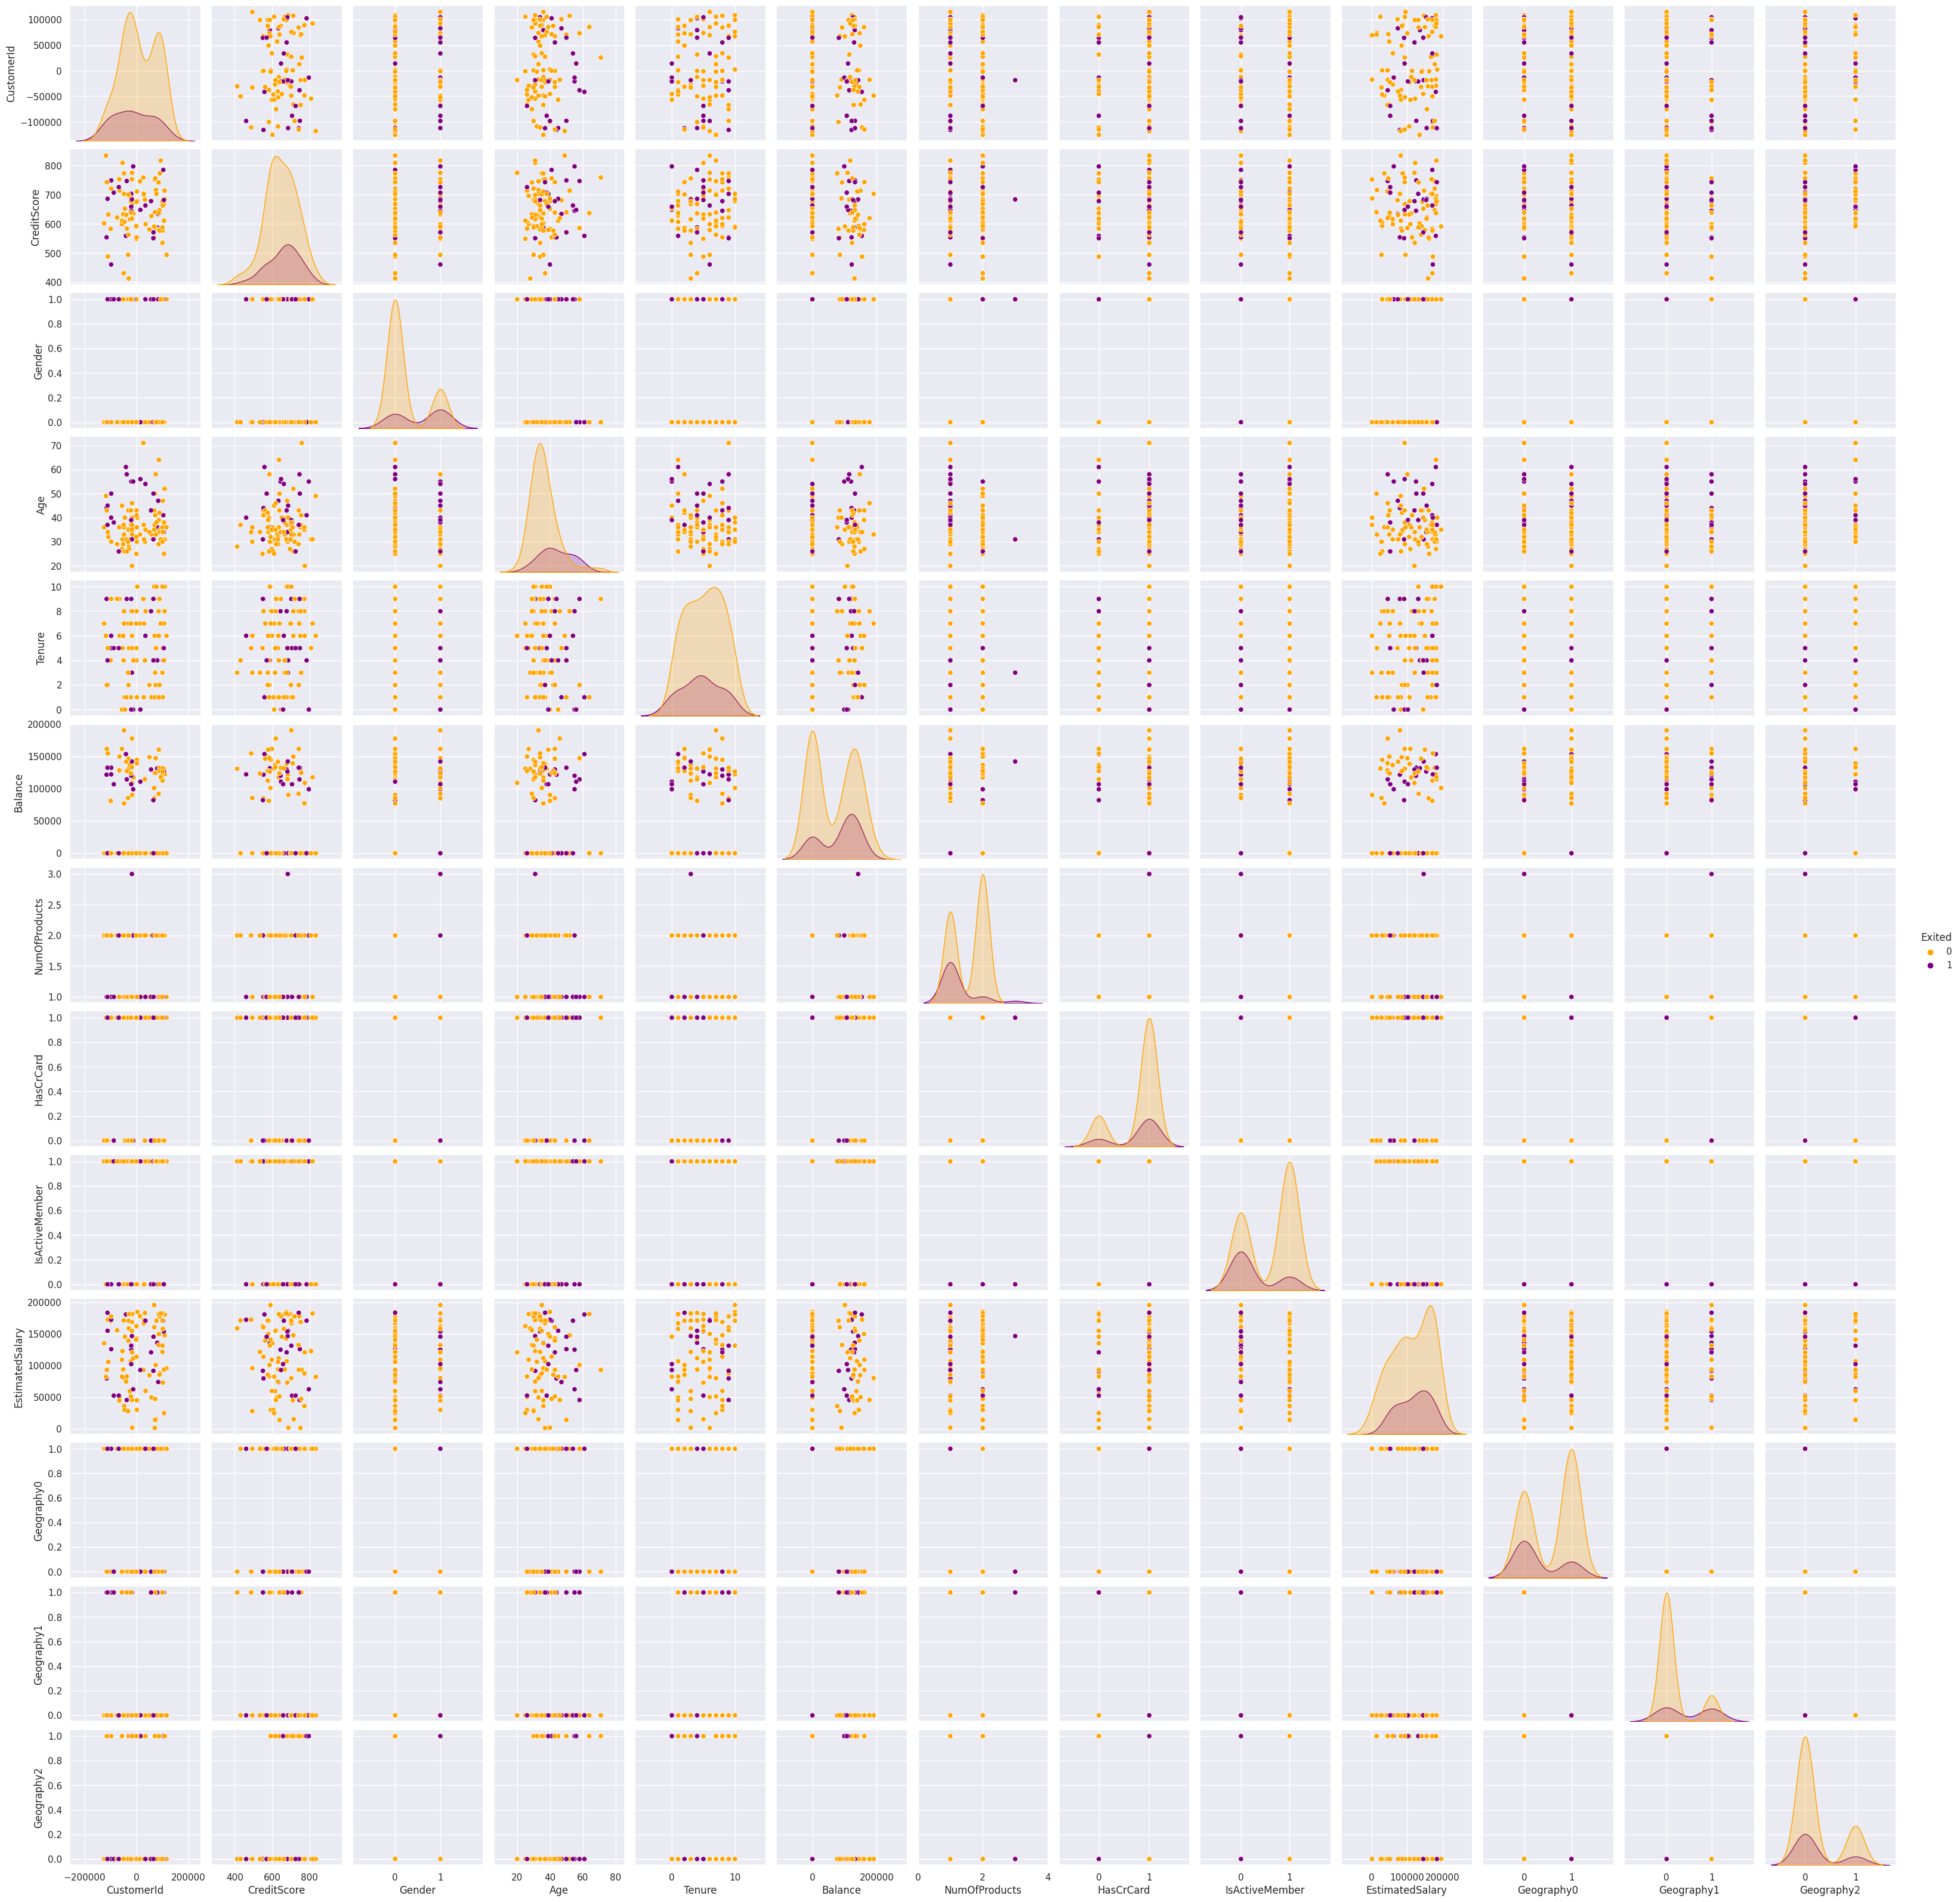

In [ ]:
df['Exited']=df['Exited'].astype(str)
sns.pairplot(df.iloc[:100], hue='Exited', palette=accent1)
plt.show()

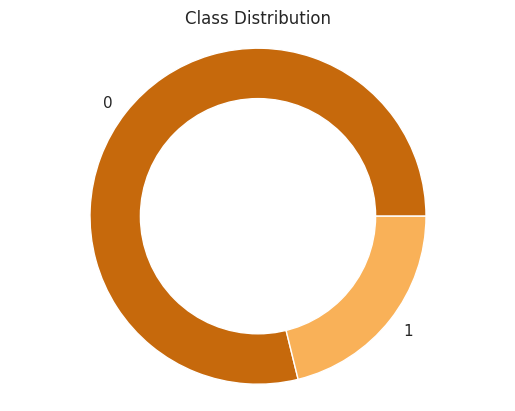

In [ ]:
labels, sizes = df['Exited'].value_counts().index, df['Exited'].value_counts().values
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)
ax.axis('equal')
plt.title('Class Distribution')
plt.show()

# PreProcessing

In [ ]:
df = df.drop(['id', 'Surname'], axis=1)
df['CustomerId'] = df['CustomerId'] - df['CustomerId'].mean()
df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='Male' else 1)

In [ ]:
one_hot_cols = ['Geography']
ohe = OneHotEncoder()
ohe.fit(df[one_hot_cols])

OneHotEncoder()

In [ ]:
encoded_cols = ohe.transform(df[one_hot_cols])
df = pd.concat([df.drop(one_hot_cols, axis=1),
                pd.DataFrame(encoded_cols.toarray()).add_prefix('Geography')],
                axis=1)

In [ ]:
Y = df['Exited'].values
X = df.drop(['Exited'], axis=1).values

In [ ]:
ss = StandardScaler()
ss.fit(X)

StandardScaler()

In [ ]:
X = ss.transform(X)

In [ ]:
def PreProc(df, ohe=ohe, ss=ss):
    one_hot_cols = ['Geography']

    df = df.drop(['id', 'Surname'], axis=1)
    df['CustomerId'] = df['CustomerId'] - df['CustomerId'].mean()
    df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='Male' else 1)
    encoded_cols = ohe.transform(df[one_hot_cols])
    df = pd.concat([df.drop(one_hot_cols, axis=1),
                    pd.DataFrame(encoded_cols.toarray()).add_prefix('Geography')],
                    axis=1)
    X = df.values
    X = ss.transform(X)
    return X

In [ ]:
X_Test = PreProc(df_test)

### SMOTE Upsampling

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 0.75,
           random_state=69)
X, Y = sm.fit_resample(X, Y)

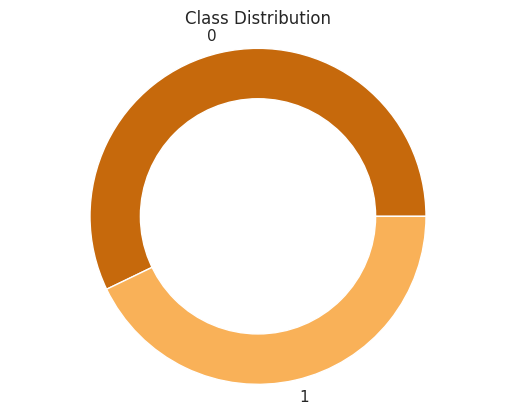

In [ ]:
labels, sizes = np.unique(Y, return_counts=True)
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)
ax.axis('equal')
plt.title('Class Distribution')
plt.show()

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2)

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((216312,), (2277,), (9108,))

In [ ]:
def score_metrics(y_test, prediction, labels=None, confmat=True):
    print('f1_score : ', f1_score(y_test, prediction, average=None))
    print('auc_roc : ', roc_auc_score(y_test, prediction, average=None))
    print('accuracy : ', accuracy_score(y_test, prediction))
    if confmat:
        cm = confusion_matrix(y_test, prediction)

        class_labels = [0, 1]
        sns.heatmap(cm, annot=True, fmt='d', cmap=SNS_CMAP, xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        plt.show()

# Baseline Models

In [ ]:
if mode=="colab":
  !pip install catboost

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
models = {
    'LogisticRegression' : LogisticRegression,
#     'SVC' : SVC,
    'DecisionTreeClassifier' : DecisionTreeClassifier,
    'RandomForestClassifier' : RandomForestClassifier,
    'GaussianNB' : GaussianNB,
    'GradientBoostingClassifier' : GradientBoostingClassifier,
    'AdaBoostClassifier' : AdaBoostClassifier,
    'XGBClassifier' : XGBClassifier,
    'LGBMClassifier' : LGBMClassifier,
    'CatBoostClassifier' : CatBoostClassifier
}

In [ ]:
def baseline_metrics(x_train, y_train, x_val, y_val):
    for i, (name, classifier) in enumerate(models.items()):
        model = classifier()
        print(f'{i+1}. {name}')
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        try:
            print(f'Score : {model.score(x_train, y_train)}')
        except:
            print("Unable to score")
        score_metrics(y_val, y_pred)
        print('-----------------------------------------------')

1. LogisticRegression
Score : 0.7598006583083694
f1_score :  [0.7985846  0.71071285]
auc_roc :  0.7522748251956483
accuracy :  0.7625164690382081


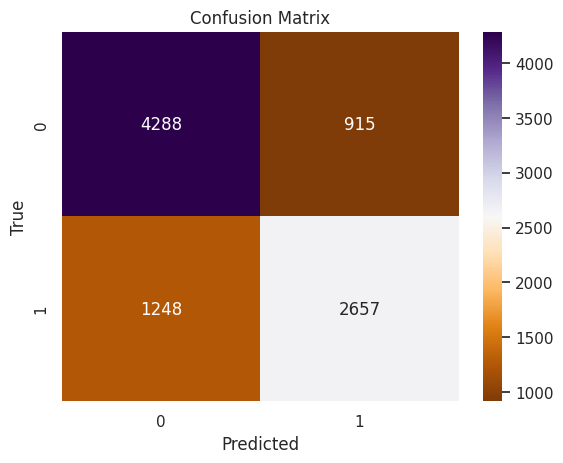

-----------------------------------------------
2. DecisionTreeClassifier
Score : 0.9999121639113873
f1_score :  [0.85744784 0.81430919]
auc_roc :  0.8369827266501179
accuracy :  0.8387132191480018


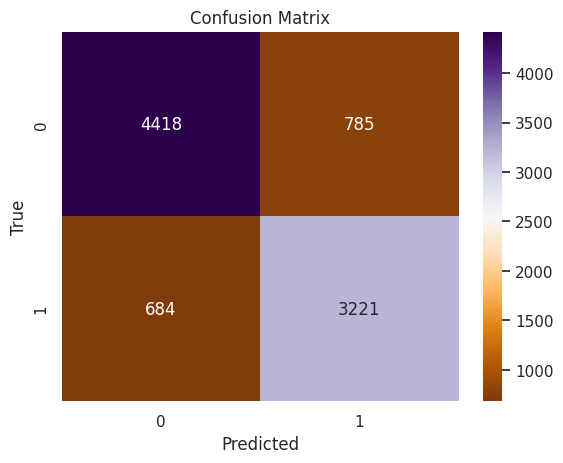

-----------------------------------------------
3. RandomForestClassifier
Score : 0.999907540959355
f1_score :  [0.91112172 0.8797313 ]
auc_roc :  0.894561100989949
accuracy :  0.8977821695213


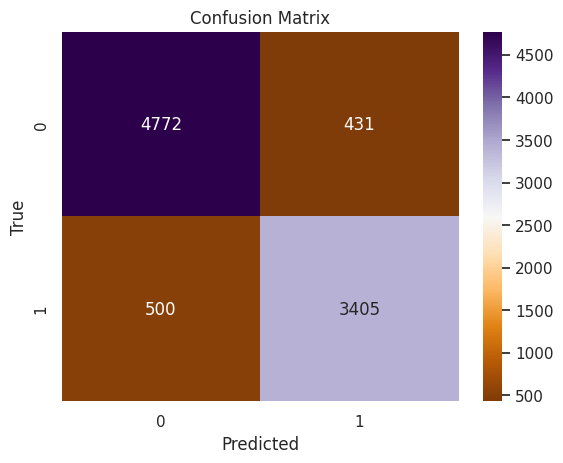

-----------------------------------------------
4. GaussianNB
Score : 0.7296451422020045
f1_score :  [0.76927416 0.6762533 ]
auc_roc :  0.7213075879841803
accuracy :  0.730566534914361


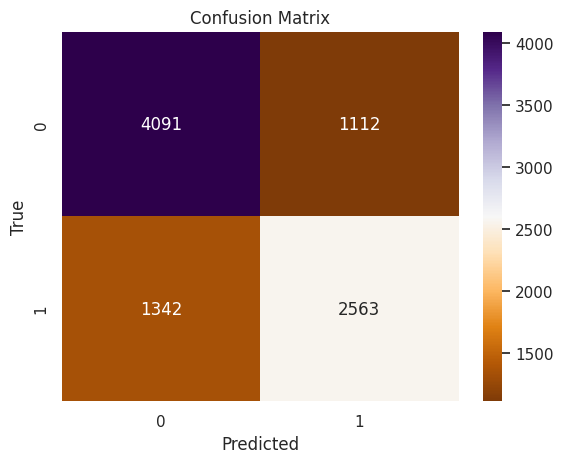

-----------------------------------------------
5. GradientBoostingClassifier
Score : 0.8613484226487665
f1_score :  [0.87814059 0.82935828]
auc_roc :  0.8513400990219618
accuracy :  0.8578173034694774


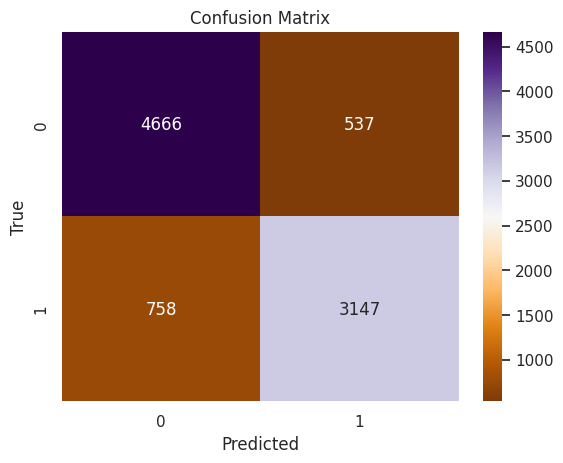

-----------------------------------------------
6. AdaBoostClassifier
Score : 0.8247901179777358
f1_score :  [0.85044875 0.79255668]
auc_roc :  0.819734822542791
accuracy :  0.8261967501097935


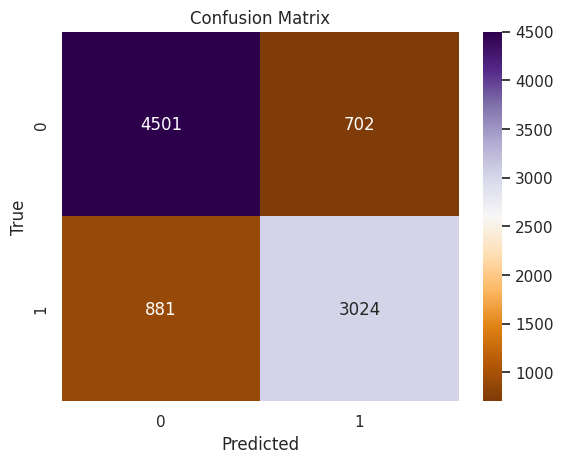

-----------------------------------------------
7. XGBClassifier
Score : 0.8957431857687045
f1_score :  [0.90386596 0.86366653]
auc_roc :  0.8804803837439397
accuracy :  0.8872419850680721


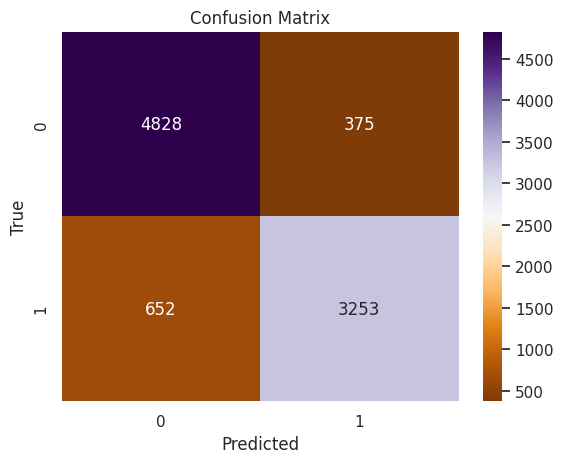

-----------------------------------------------
8. LGBMClassifier
Score : 0.8959650874662525
f1_score :  [0.9088009  0.87139455]
auc_roc :  0.8870434987398927
accuracy :  0.8932806324110671


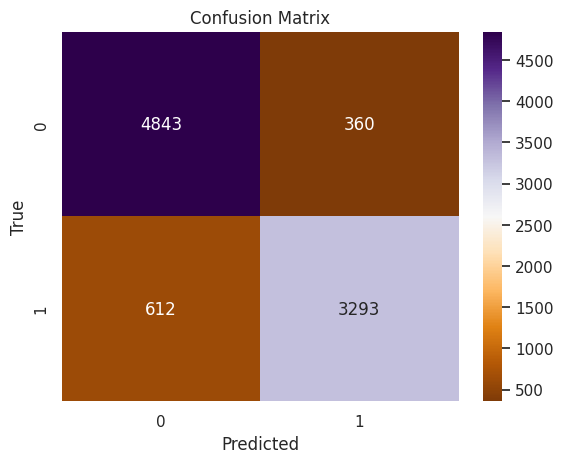

-----------------------------------------------
9. CatBoostClassifier
Learning rate set to 0.102332
0:	learn: 0.6288739	total: 41.4ms	remaining: 41.4s
1:	learn: 0.5817890	total: 74.2ms	remaining: 37s
2:	learn: 0.5465150	total: 111ms	remaining: 36.8s
3:	learn: 0.5187511	total: 144ms	remaining: 35.9s
4:	learn: 0.4983662	total: 186ms	remaining: 37s
5:	learn: 0.4823549	total: 220ms	remaining: 36.4s
6:	learn: 0.4685728	total: 254ms	remaining: 36s
7:	learn: 0.4579904	total: 289ms	remaining: 35.9s
8:	learn: 0.4485033	total: 325ms	remaining: 35.7s
9:	learn: 0.4404323	total: 360ms	remaining: 35.7s
10:	learn: 0.4311103	total: 400ms	remaining: 36s
11:	learn: 0.4256470	total: 436ms	remaining: 35.9s
12:	learn: 0.4206549	total: 470ms	remaining: 35.7s
13:	learn: 0.4149728	total: 504ms	remaining: 35.5s
14:	learn: 0.4092492	total: 540ms	remaining: 35.4s
15:	learn: 0.4065157	total: 572ms	remaining: 35.2s
16:	learn: 0.3998407	total: 612ms	remaining: 35.4s
17:	learn: 0.3962795	total: 648ms	remaining: 35.4

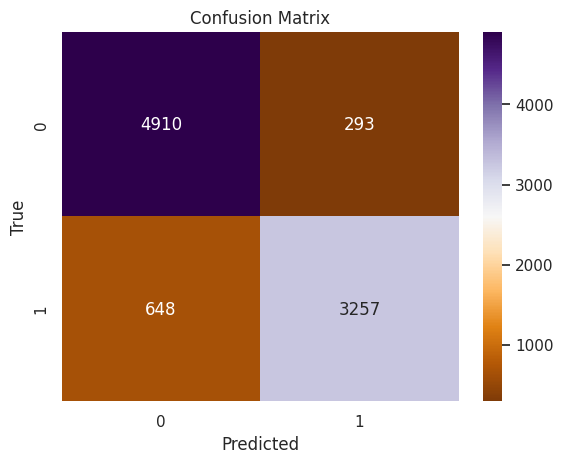

-----------------------------------------------


In [ ]:
baseline_metrics(x_train, y_train, x_val, y_val)

# RandomForest Hyperparam tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
    'max_depth' : [None, 5, 10, 20, 50, 80, 110, 140, 170, 200],
    'min_samples_split' : [1, 2, 5],
    'min_samples_leaf' : [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap' : [True, False],
}

rscv = RandomizedSearchCV(param_distributions = random_grid,
                          estimator=RandomForestClassifier(),
                          n_iter = 20, cv = 3, random_state=69, n_jobs = -1)
rscv.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 50, 80,
                                                      110, 140, 170, 200],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 2, 5]},
                   random_state=69)

In [ ]:
rscv.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [ ]:
best_rf_ = {'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}
rf_optim = RandomForestClassifier(**best_rf_)
rf_optim.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5)

In [ ]:
rf_optim.score(x_val, y_val)

0.8974527887571366

f1_score :  [0.91316094 0.88537952]
auc_roc :  0.9024019611725846
accuracy :  0.9011857707509882


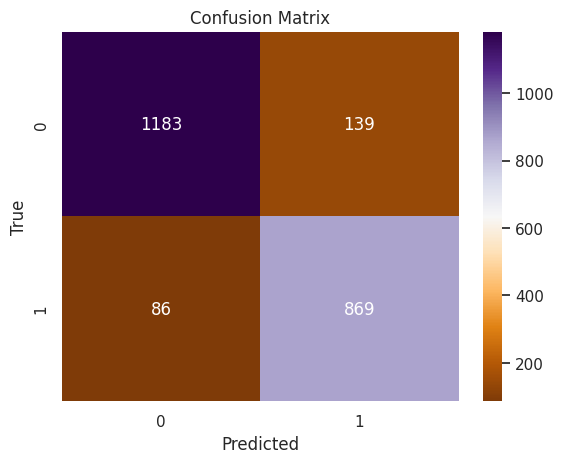

In [ ]:
y_pred = rf_optim.predict(x_test)
score_metrics(y_pred, y_test)

In [ ]:
prediction = rf_optim.predict_proba(X_Test)

# XGboost with BayesianOpt

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV

In [ ]:
search_space = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [1e-9, 0.5],
    'scale_pos_weight': [1e-6, 500],  # Adjusted bounds for log-uniform
    'n_estimators': [30, 50, 100, 300, 500, 800, 1200],
    'max_depth': (3, 7, 10),
    'min_child_weight': (1, 3),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.8, 1.0),
}

bayes_search = BayesSearchCV(
    xgb.XGBClassifier(),
    search_space,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
)

np.int = int
bayes_search.fit(x_train, y_train)

In [ ]:
bayes_search.best_params_

In [ ]:
xgb_model = xgb.XGBClassifier(
             colsample_bytree= 0.9335775071754608,
             gamma= 0.23425986690752887,
             learning_rate=0.01,
             max_depth=7,
             min_child_weight=2,
             n_estimators=1200,
             scale_pos_weight=211,
             subsample=0.8578018040119446
)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9335775071754608, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.23425986690752887,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

f1_score :  [0.13674602 0.6181012 ]
auc_roc :  0.7210890933058229
accuracy :  0.4704655248133509


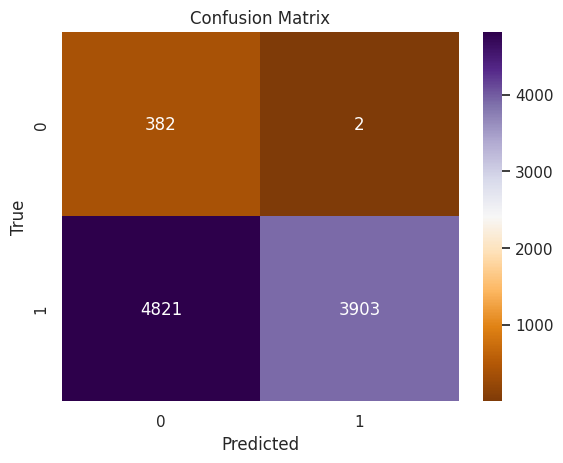

In [ ]:
y_pred = xgb_model.predict(x_val)
score_metrics(y_pred, y_val)

# Catboost with Optuna

In [ ]:
import catboost
import optuna
from sklearn.metrics import accuracy_score

In [ ]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = catboost.CatBoostClassifier(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    return accuracy_score(predictions, y_val)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

In [ ]:
study.best_params

In [ ]:
best_params = {'learning_rate': 0.05576744016332533,
 'depth': 9,
 'subsample': 0.9975171321042826,
 'colsample_bylevel': 0.7530490864600647,
 'min_data_in_leaf': 9}

cat_model = catboost.CatBoostClassifier(**best_params, silent=True)
cat_model.fit(x_train, y_train)

f1_score :  [0.91352509 0.8756858 ]
auc_roc :  0.9013902154732804
accuracy :  0.8980017566974089


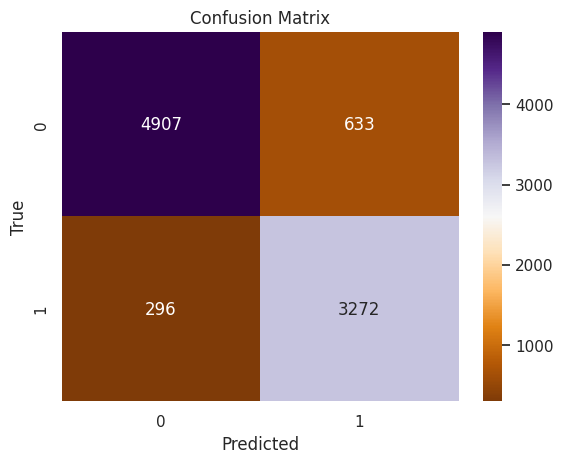

In [ ]:
y_pred = cat_model.predict(x_val)
score_metrics(y_pred, y_val)

In [ ]:
prediction = cat_model.predict_proba(X_Test)

In [ ]:
prediction

array([[0.98159254, 0.01840746],
       [0.12979883, 0.87020117],
       [0.98304308, 0.01695692],
       ...,
       [0.9798849 , 0.0201151 ],
       [0.8341991 , 0.1658009 ],
       [0.83512117, 0.16487883]])

# Tensorflow NN 128-64-32

In [ ]:
!nvidia-smi

Thu Jan 11 05:24:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

INPUT_SHAPE = X.shape[1]
BATCH_SIZE = 32
EPOCHS = 100
DROPOUT_RATE = 0.1

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 10
)

In [ ]:
import tensorflow as tf

def binary_classificn_model(input_shape, dropout_rate=0.05):
    model_inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(units=128, activation = 'relu')(model_inputs)
    x = tf.keras.layers.Dropout(rate = dropout_rate)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu')(x)
    x = tf.keras.layers.Dense(units=32, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(rate = dropout_rate)(x)
    x = tf.keras.layers.Dense(units=8, activation = 'relu')(x)
    predictions = tf.keras.layers.Dense(units=1, activation = 'sigmoid')(x)

    return tf.keras.Model(inputs=model_inputs, outputs=predictions)

model = binary_classificn_model(INPUT_SHAPE, DROPOUT_RATE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 128)               1792      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 264   

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data = (x_val, y_val),
          callbacks = [early_stop],
          shuffle=True
)

Epoch 1/100
6760/6760 [==============================] - 33s 4ms/step - loss: 0.4294 - accuracy: 0.8037 - val_loss: 0.4085 - val_accuracy: 0.8179
Epoch 2/100
6760/6760 [==============================] - 28s 4ms/step - loss: 0.4173 - accuracy: 0.8104 - val_loss: 0.4076 - val_accuracy: 0.8221
Epoch 3/100
6760/6760 [==============================] - 27s 4ms/step - loss: 0.4150 - accuracy: 0.8117 - val_loss: 0.4045 - val_accuracy: 0.8215
Epoch 4/100
6760/6760 [==============================] - 27s 4ms/step - loss: 0.4133 - accuracy: 0.8121 - val_loss: 0.4043 - val_accuracy: 0.8215
Epoch 5/100
6760/6760 [==============================] - 27s 4ms/step - loss: 0.4116 - accuracy: 0.8128 - val_loss: 0.4037 - val_accuracy: 0.8239
Epoch 6/100
6760/6760 [==============================] - 40s 6ms/step - loss: 0.4106 - accuracy: 0.8133 - val_loss: 0.4017 - val_accuracy: 0.8233
Epoch 7/100
6760/6760 [==============================] - 27s 4ms/step - loss: 0.4093 - accuracy: 0.8140 - val_loss: 0.4048 -

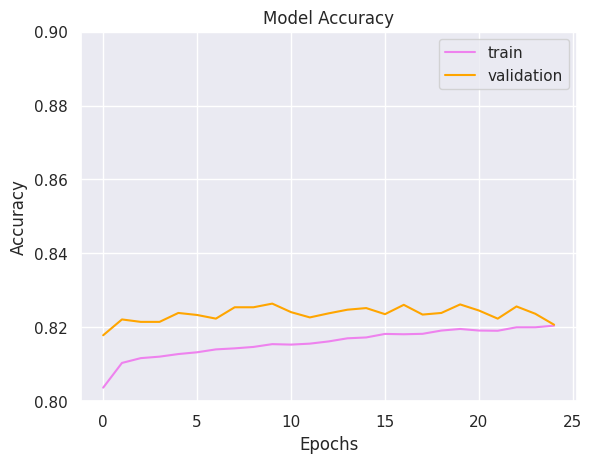

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'], color='violet')
plt.plot(history.history['val_accuracy'], color='orange')
# plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.8,ymax=0.9)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid(True)
plt.show()

285/285 [==============================] - 1s 1ms/step
f1_score :  [0.84496345 0.78745282]
auc_roc :  0.8174138140412036
accuracy :  0.8207070707070707


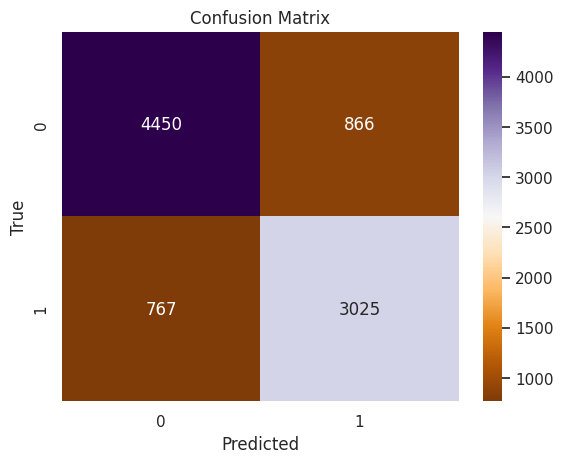

In [ ]:
y_pred = model.predict(np.expand_dims(x_val, axis=-1))>0.5
score_metrics(y_pred, y_val)

In [ ]:
prediction = model.predict(np.expand_dims(X_Test, axis=-1))
prediction = np.concatenate([1-prediction, prediction], axis=-1)

3439/3439 [==============================] - 7s 2ms/step


# SoftVoting

### Randomforest + Catboost

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
voting_classifier = VotingClassifier(
    estimators=[
        ('random_forest', rf_optim),
        ('catboost', cat_model)
    ],
    voting='soft'
)

In [ ]:
voting_classifier.fit(x_train, y_train)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=50,
                                                     min_samples_split=5)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7cc95392eec0>)],
                 voting='soft')

f1_score :  [0.92165202 0.89142109]
auc_roc :  0.909494594699685
accuracy :  0.9089811155028547


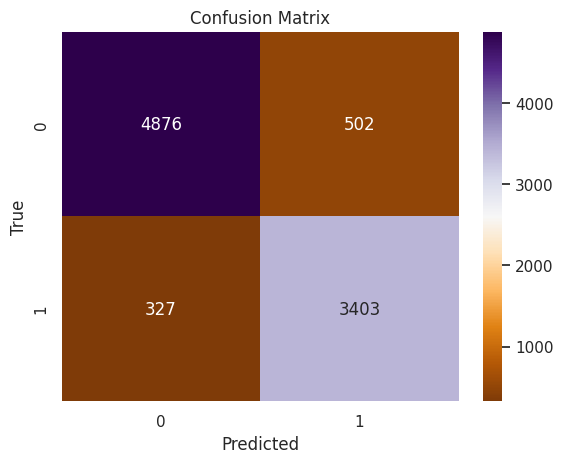

In [ ]:
y_pred = voting_classifier.predict(x_val)
score_metrics(y_pred, y_val)

In [ ]:
prediction = voting_classifier.predict_proba(X_Test)

# FInal Prediction

In [ ]:
prediction

array([[0.98954627, 0.01045373],
       [0.11448275, 0.88551725],
       [0.98610487, 0.01389513],
       ...,
       [0.98494245, 0.01505755],
       [0.74251622, 0.25748378],
       [0.84089392, 0.15910608]])

In [ ]:
df_sub = df_sample.copy()
df_sub['Exited']=prediction[:, 1]
df_sub.to_csv('submission.csv', index=False)

In [ ]:
df_sample

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5
...,...,...
110018,275052,0.5
110019,275053,0.5
110020,275054,0.5
110021,275055,0.5


In [ ]:
df_sub

,id,Exited
0,165034,0.018407
1,165035,0.870201
2,165036,0.016957
3,165037,0.204788
4,165038,0.392105
...,...,...
110018,275052,0.040598
110019,275053,0.121347
110020,275054,0.020115
110021,275055,0.165801
